# How does adaptive sampling influence post-trial inference?

The idea of this notebook is to explore the behaviour of post-inference techniques, especially (naive) frequentist and bayesian approaches to adaptive sampling.
We therefore generate a simple example and test out which biases occur.

Please note that the example and the policies are not necessarily **good**, but are designed to show how the biases occur.

## Assumptions:
Generated outcome may only depend on current context and treatment, which means especially no crossover effects and instantaneous effects.
While this will usually **not** be the case, an proper study design should enable analysis based on these assumptions.

## Running example

Let's consider we want to compare to treatments Treatment_1 and Treatment_2.
We assume Treatment_1 has an average treatment effect of 1, and Treatment_2 has an average treatment effect of 2 both with a variance of 1.
We first compare a frequentist analysis in an AB design. By simulating 10000 trials with 100 observations each and looking at the estimates

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az

In [4]:
# Set some constants
n_trials = 1000
n_observations = 100
sigma = 1

In [3]:
df = pd.DataFrame(columns=["outcome", "treatment", "trial"])
# Simple AB treatment schedule
df["treatment"] = [1, 2] * n_observations * int(n_trials / 2)
df["trial"] = df.index // n_observations
df["outcome"] = (df["treatment"] == 1) * np.random.normal(1, sigma, len(df)) + (
    df["treatment"] == 2
) * np.random.normal(2, sigma, len(df))
df_fixed_schedule = df

The histogram of estimated treatment effects by using a simple mean of this schedule shows two similar gaussian bell curves with different means.

<Axes: xlabel='Count', ylabel='outcome'>

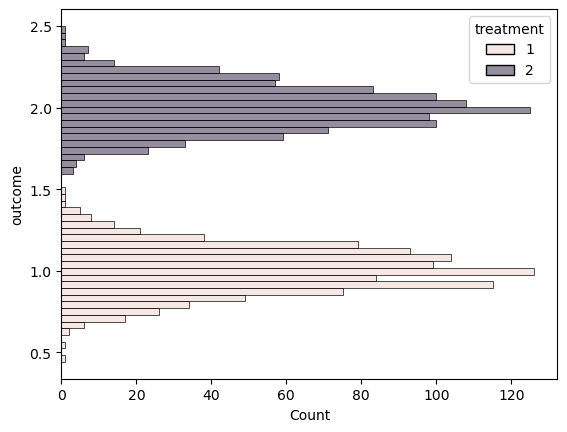

In [4]:
sns.histplot(
    data=df_fixed_schedule.groupby(["trial", "treatment"]).mean(),
    y="outcome",
    hue="treatment",
    bins=50,
)

## "Play the Winner"-Bias
Let's assume a simple policy: we test both treatments one time, and then only choose the best one (equals a explore-then-commit policy with n=1).
This will induce a "play-the-winner"-bias. 

See also:
Bowden, J., & Trippa, L. (2017). Unbiased estimation for response adaptive clinical trials. Statistical Methods in Medical Research, 26(5), 2376–2388. https://doi.org/10.1177/0962280215597716

In [5]:
df = pd.DataFrame(columns=["outcome", "treatment", "trial"])
# Simple AB treatment schedule
df["treatment"] = [1, 2] * n_observations * int(n_trials / 2)
df["outcome"] = (df["treatment"] == 1) * np.random.normal(1, sigma, len(df)) + (
    df["treatment"] == 2
) * np.random.normal(2, sigma, len(df))
df["trial"] = df.index // n_observations

# All rows are adaptive except the first two of every trial
df["adaptive"] = df.index % n_observations > 1
df_pivoted = df.loc[~df["adaptive"]].pivot(
    index="trial", values="outcome", columns="treatment"
)
df_pivoted["better_treatment"] = np.where(df_pivoted[1] > df_pivoted[2], 1, 2)

# Add the better_treatment to the original dataset
df = df.join(df_pivoted, on="trial")

# Set the adaptive treatments to the better treatment
df["treatment"] = np.where(df["adaptive"], df["better_treatment"], df["treatment"])

# Update the observations
df["outcome"] = np.where(
    df["adaptive"],
    (df["treatment"] == 1) * np.random.normal(1, sigma, len(df))
    + (df["treatment"] == 2) * np.random.normal(2, sigma, len(df)),
    df["outcome"],
)
df_play_the_winner = df

The "Play the Winner"-Rule deforms the bell curves.
Instead of one homogenous bell curve, both treatments show an addition of two bell curves: One very narrow for trials where we choose the respective treatment as winner, and one very wide one where the respective treatment lost and was therefore only sampled once. 

Because we generate a lot more data points for Treatment 2 (the better treatment), we see a narrower histogram, and the distribution for Treatment 1 is wider.

<Axes: xlabel='Count', ylabel='outcome'>

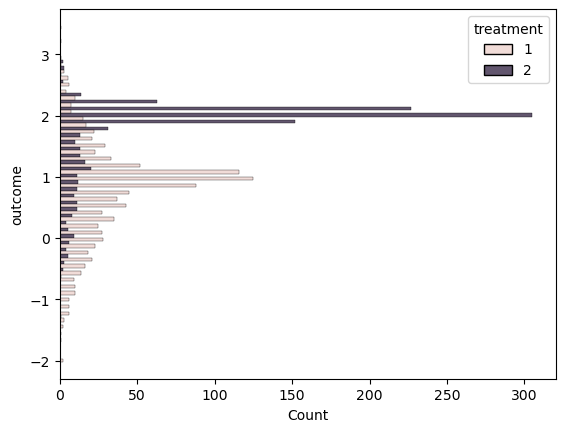

In [6]:
sns.histplot(
    data=df_play_the_winner.groupby(["trial", "treatment"]).mean(),
    y="outcome",
    hue="treatment",
    bins=50,
    multiple="dodge",
)

We know want to compare the post-inference after both trials.
Therefore, we calculate the average treatment effect estimant over all trials, and average it.

We observe a small bias that makes the estimated treatment effect smaller than it is.

In [7]:
print(df_fixed_schedule.groupby(["trial", "treatment"]).mean()["outcome"][:, 2].mean())
print(df_play_the_winner.groupby(["trial", "treatment"]).mean()["outcome"][:, 2].mean())
print(
    f'Measured bias for treatment 2: {(df_fixed_schedule.groupby(["trial", "treatment"]).mean()["outcome"][:,2].mean() - df_play_the_winner.groupby(["trial", "treatment"]).mean()["outcome"][:, 2].mean()):.10f}'
)

2.003033695314462
1.7773147784653738
Measured bias for treatment 2: 0.2257189168


## Bayesian Inference

Let's look at a possible analysis of one of the trials using bayesian statistics.

One major advantage is that the bayesian model can incorporate uncertainty.
We see that with this model, we can only make a big confidence interval of the effect for treatment 1, as we only have one datapoint, but we are confident that the effect for treatment 2 is between 1.8 and 2.2.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [average_treatment_effect]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


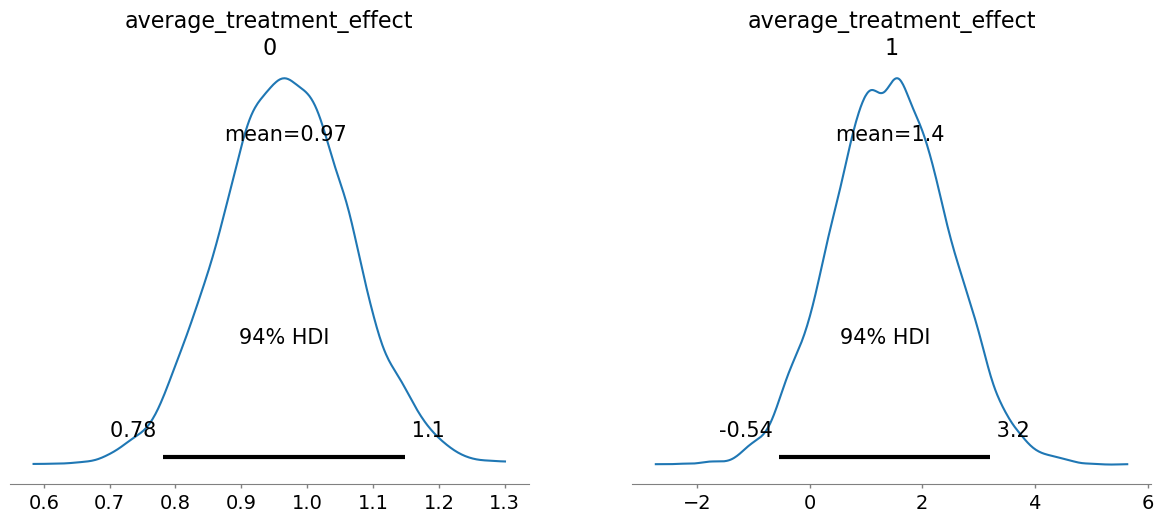

In [8]:
model = pm.Model()

with model:
    df_trial = df_play_the_winner[df_play_the_winner["trial"] == 0]
    treatments = df_trial["treatment"]
    # Priors for unknown model parameters
    average_treatment_effect = pm.Normal(
        "average_treatment_effect", mu=0, sigma=100, shape=2
    )
    outcome = pm.Normal(
        "outcome",
        mu=(
            np.array(df_trial["treatment"] == 1) * average_treatment_effect[0]
            + np.array(df_trial["treatment"] == 2) * average_treatment_effect[1]
        ),
        sigma=sigma,
        observed=df_trial["outcome"],
    )
    trace = pm.sample(3000)
    az.plot_posterior(trace)

### What do I need to do?

Please not that this bias occurs, if we take an **unweighted** average over the estimated treatments effects per trial, when we should not do so, since we are way more confident in the trials where we observe multiple results for the treatment.
If we take an average over all treatments, the estimants remain unbiased.

Best practice would be to test out the desired policy in a simulation study.
The bias should be smaller if using a less extreme version of an adaptive policy.
The estimate for Treatment 2 under the adaptive regime might be biased, but if analyzed correctyly will be better than under fixed schedule due to more sample points for the better treatment.

## Contextual Bias
Another potential bias we can get is contextual bias. If our policy introduces a dependency between contextual variable and treatment, and we do not control for it, we might take it as a treatment effect. Note that this is not only a problem with adaptive schedules, since it can also happen with fixed schedules.
However, it might be more likely with contextual bandit algorithms, since the bandit can learn to make a decision based on a contextual variable.

Let's consider a binary contextual variable c that can have a positive additive effect on outcome, and (by chance) is only 1 when we give treatment 2.

In [9]:
df = pd.DataFrame(columns=["outcome", "treatment", "trial"])
# Simple AB treatment schedule
df["treatment"] = [1, 2] * n_observations * int(n_trials / 2)
df["trial"] = df.index // n_observations
df["context"] = df["treatment"] - 1
df["outcome"] = (
    (df["treatment"] == 1) * np.random.normal(1, 1, len(df))
    + (df["treatment"] == 2) * np.random.normal(2, 1, len(df))
    + df["context"]
)
df_fixed_schedule = df
df_play_the_winner = df

<Axes: xlabel='Count', ylabel='outcome'>

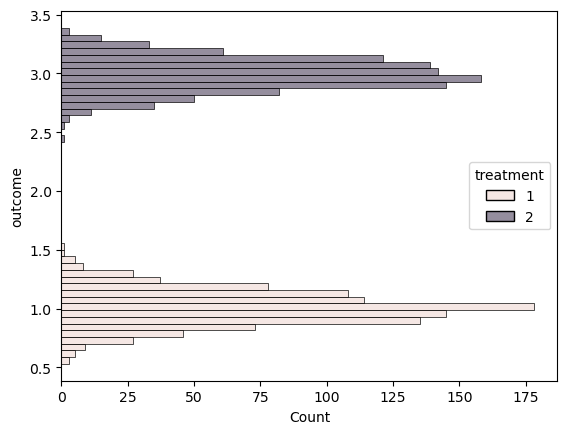

In [10]:
sns.histplot(
    data=df_play_the_winner.groupby(["trial", "treatment"]).mean(),
    y="outcome",
    hue="treatment",
    bins=50,
)

A naive mean will overestimate the treatment effect to 3, since we are not able to control for c.

### What do I need to do?
Check if covariates are independent of treatment schedule, or control for non-independence.
Here, we have a strong dependence from time t <--> treatment. Adaptive policies might introduce more of these dependencies.
A special case of this might also be a baseline shift in the data. While a baseline shift violates our assumptions, modeling the baseline as a covariate might make the assumption valid again, but induce covariate bias.

# Updating Priors: Correctly updating the variance

Test:
- A: Random Design
- B: Adaptive Design with 0.5 chance to choose Treatment 1 based on a covariate (which is the random effect)


In [30]:
rng = np.random.default_rng()

df = pd.DataFrame(columns=["outcome", "trial","context"])
# Simple AB treatment schedule
df["fixed_treatment"] = [1, 2] * n_observations * int(n_trials / 2)
df["trial"] = df.index // n_observations
df["context"] = np.random.normal(2,1, len(df))
df["adaptive_treatment"] = np.where(df["context"] > 2, rng.choice([1,2], len(df), p=[0.1, 0.9]), rng.choice([1,2], len(df), p=[0.9,0.1]))
df["fixed_outcome"] = (
    (df["fixed_treatment"] == 1) * np.random.normal(1, 1, len(df))
    + (df["fixed_treatment"] == 2) * df["context"]
)
df["adaptive_outcome"] = (
    (df["adaptive_treatment"] == 1) * np.random.normal(1, 1, len(df))
    + (df["adaptive_treatment"] == 2) * df["context"]
)
df_bayesian_prior_update = df

In [32]:
df_bayesian_prior_update.sum()

outcome                           0
trial                      49950000
context               200023.596015
fixed_treatment              150000
adaptive_treatment           150058
fixed_outcome         150181.581489
adaptive_outcome      181996.592084
dtype: object

<Axes: xlabel='Count', ylabel='adaptive_outcome'>

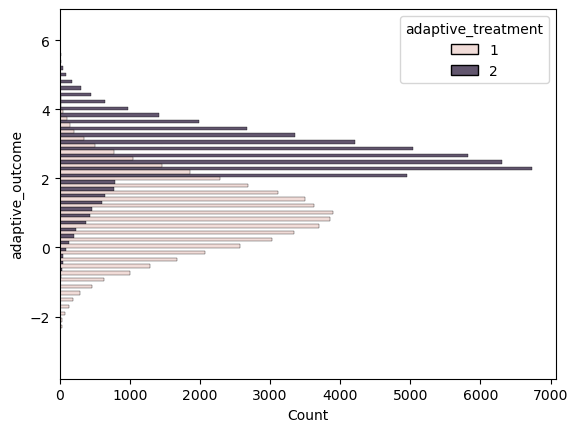

In [38]:
sns.histplot(
    data=df_bayesian_prior_update,
    y="adaptive_outcome",
    hue="adaptive_treatment",
    bins=50,
    multiple="dodge",
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [average_treatment_effect]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 9 seconds.


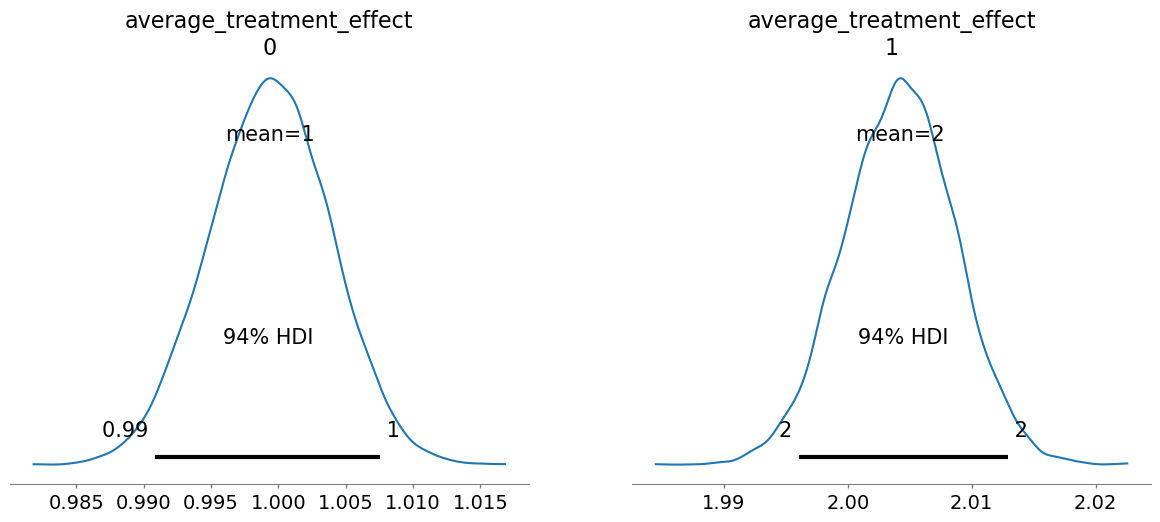

In [33]:
model = pm.Model()

with model:
    df_trial = df_bayesian_prior_update
    treatments = df_trial["adaptive_treatment"]
    # Priors for unknown model parameters
    average_treatment_effect = pm.Normal(
        "average_treatment_effect", mu=0, sigma=100, shape=2
    )
    outcome = pm.Normal(
        "outcome",
        mu=(
            np.array(df_trial["fixed_treatment"] == 1) * average_treatment_effect[0]
            + np.array(df_trial["fixed_treatment"] == 2) * average_treatment_effect[1]
        ),
        sigma=sigma,
        observed=df_trial["fixed_outcome"],
    )
    trace = pm.sample(3000)
    az.plot_posterior(trace)

# Fixed Outcome

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, average_treatment_effect]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 13 seconds.


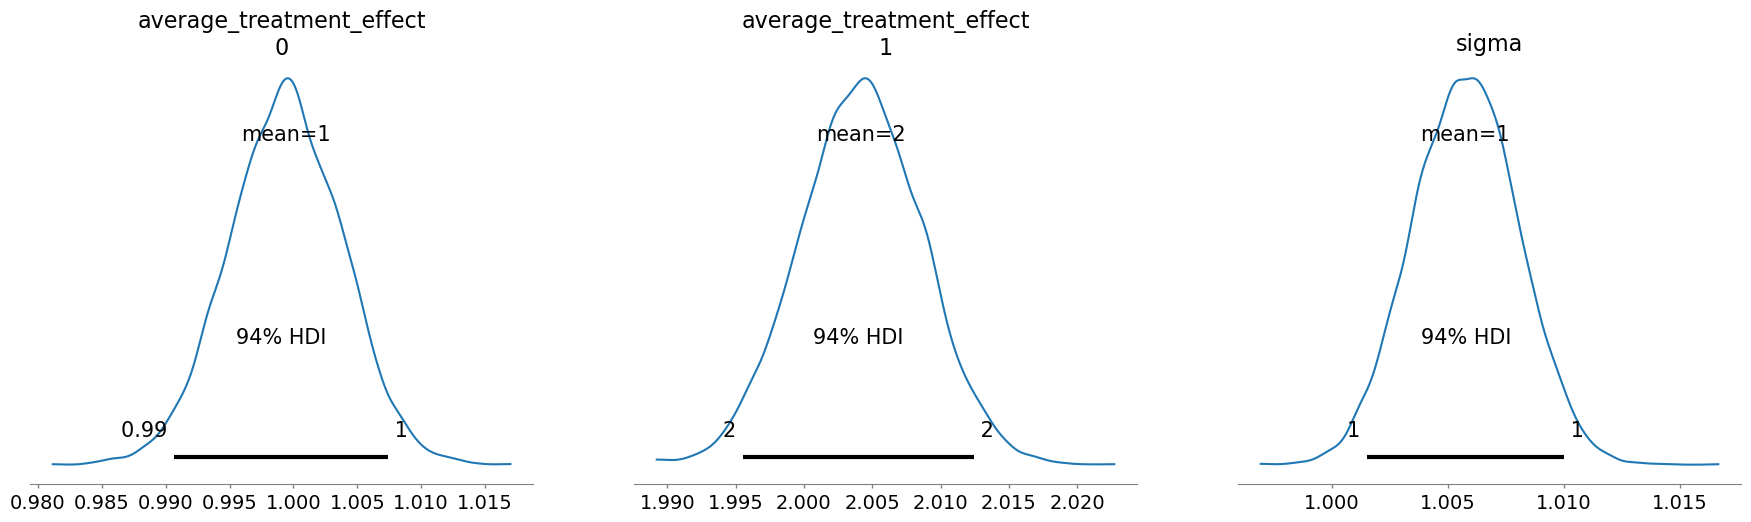

In [43]:
model = pm.Model()
with model:
    df_trial = df_bayesian_prior_update
    treatments = df_trial["fixed_treatment"]
    # Priors for unknown model parameters
    sigma = pm.HalfNormal("sigma", sigma=10)
    average_treatment_effect = pm.Normal(
        "average_treatment_effect", mu=0, sigma=sigma, shape=2
    )
    outcome = pm.Normal(
        "outcome",
        mu=(
            np.array(treatments == 1) * average_treatment_effect[0]
            + np.array(treatments == 2) * average_treatment_effect[1]
        ),
        sigma=sigma,
        observed=df_trial["fixed_outcome"],
    )
    trace = pm.sample(3000)
    az.plot_posterior(trace)
#az.plot_trace(trace)

# Adaptive Outcome

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, average_treatment_effect]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 14 seconds.


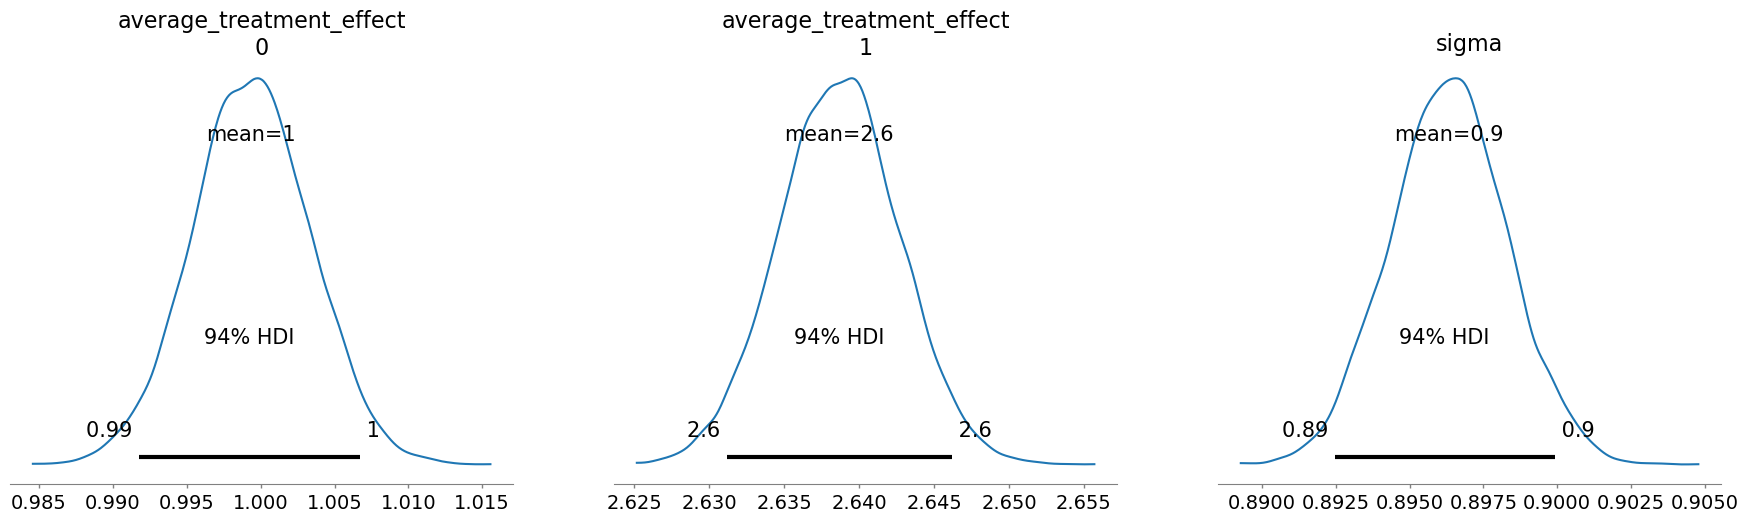

In [44]:
model = pm.Model()
with model:
    df_trial = df_bayesian_prior_update
    treatments = df_trial["adaptive_treatment"]
    # Priors for unknown model parameters
    sigma = pm.HalfNormal("sigma", sigma=10)
    average_treatment_effect = pm.Normal(
        "average_treatment_effect", mu=0, sigma=sigma, shape=2
    )
    outcome = pm.Normal(
        "outcome",
        mu=(
            np.array(treatments == 1) * average_treatment_effect[0]
            + np.array(treatments == 2) * average_treatment_effect[1]
        ),
        sigma=sigma,
        observed=df_trial["adaptive_outcome"],
    )
    trace = pm.sample(3000)
    az.plot_posterior(trace)
#az.plot_trace(trace)